In [8]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, concatenate, GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.optimizers import Adam
import keras.backend as K

In [9]:
!pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [10]:
import tensorflow as tf
import os
import shutil
import random
import pandas as pd

# 定义文件夹路径
dataset_path = "Rice_Image_Dataset"  # 替换成您的数据集路径
dataset_name = "Rice_Image_Dataset"  # 数据集名称
# 定义类别和比例
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
train_frac = 0.7
val_frac = 0.15
test_frac = 0.15
# 创建训练集、验证集和测试集文件夹
os.makedirs(os.path.join(dataset_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(dataset_path, 'test'), exist_ok=True)

In [11]:
# Creating subfolders for each category in the train and test folders
for PlantVillage in classes:
    os.makedirs(os.path.join(dataset_path, 'train', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'test', PlantVillage), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'val', PlantVillage), exist_ok=True)

In [12]:
# 创建一个空的 DataFrame
df = pd.DataFrame(columns=['class', 'trainset', 'testset','valset'])

print('{:^18} {:^18} {:^18} {:^18}'.format('类别', '训练集数据个数', '测试集数据个数','验证集数据个数'))

for rice in classes: # 遍历每个类别
    dataset_path2 = "Rice_Image_Dataset" 
    # 读取该类别的所有图像文件名
    old_dir = os.path.join(dataset_path, rice)
    images_filename = os.listdir(old_dir)
    random.shuffle(images_filename) # 随机打乱

    # 划分训练集和测试集
    testset_number = int(len(images_filename) * test_frac) 
    valset_number = int(len(images_filename) * val_frac)
    train_number = int(len(images_filename) * train_frac)


    testset_images = images_filename[:testset_number]
    valset_images = images_filename[testset_number:testset_number + valset_number]
    trainset_images = images_filename[testset_number + valset_number: testset_number + valset_number + train_number]


    # 移动图像至 test 目录
    for image in testset_images:
        old_img_path = os.path.join(dataset_path, rice, image)         # 获取原始文件路径
        new_test_path = os.path.join(dataset_path, 'test', rice, image) # 获取 test 目录的新文件路径
        shutil.move(old_img_path, new_test_path) # 移动文件

    # 移动图像至 train 目录
    for image in trainset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_train_path = os.path.join(dataset_path, 'train', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_train_path) # 移动文件
    # 移动图像至 val 目录
    for image in valset_images:
        old_img_path = os.path.join(dataset_path, rice, image)           # 获取原始文件路径
        new_val_path = os.path.join(dataset_path, 'val', rice, image) # 获取 train 目录的新文件路径
        shutil.move(old_img_path, new_val_path) # 移动文件
    # 删除旧文件夹
    assert len(os.listdir(old_dir)) == 0 # 确保旧文件夹中的所有图像都被移动走
    shutil.rmtree(old_dir) # 删除文件夹
    
    # 工整地输出每一类别的数据个数
    print('{:^18} {:^18} {:^18} {:^18}'.format(rice, len(trainset_images), len(testset_images),len(valset_images)))
    
    # 保存到表格中
    df = pd.concat([
    df,
    pd.DataFrame({
        'class': [rice],
        'trainset': [len(trainset_images)],
        'testset': [len(testset_images)],
        'valset': [len(valset_images)]
      })
], ignore_index=True)

# 重命名数据集文件夹
shutil.move(dataset_path, dataset_name+'_split')

# 数据集各类别数量统计表格，导出为 csv 文件
df['total'] = df['trainset'] + df['testset'] + df['valset']
df.to_csv('数据量统计.csv', index=False)

        类别              训练集数据个数            测试集数据个数            验证集数据个数      
     Arborio             10500               2250               2250       
     Basmati             10500               2250               2250       
      Ipsala             10500               2250               2250       
     Jasmine             10500               2250               2250       
    Karacadag            10500               2250               2250       


In [13]:
df

,class,trainset,testset,valset,total
0,Arborio,10500,2250,2250,15000
1,Basmati,10500,2250,2250,15000
2,Ipsala,10500,2250,2250,15000
3,Jasmine,10500,2250,2250,15000
4,Karacadag,10500,2250,2250,15000


In [14]:
dataset_dir = 'Rice_Image_Dataset_split'

In [15]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
val_dir = os.path.join(dataset_dir, 'val')

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,  # Specify the validation split here
    fill_mode='nearest'
)

In [17]:
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [18]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle = False
)

Found 42000 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [25]:
# 导入所需的库
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 定义数据路径和参数
train_data_dir = 'Rice_Image_Dataset_split/train'
validation_data_dir = 'Rice_Image_Dataset_split/val'
input_shape = (128, 128)
batch_size = 32
num_classes = 5

# 数据增强
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=input_shape, batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=input_shape, batch_size=batch_size, class_mode='categorical')

# 加载 DenseNet 模型
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# 冻结所有层
for layer in base_model.layers:
    layer.trainable = False

# 添加自定义层
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 构建新模型
model3 = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# 编译模型
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 训练模型
history = model3.fit(train_generator, steps_per_epoch=len(train_generator), epochs=30, validation_data=validation_generator, validation_steps=len(validation_generator))


Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Epoch 1/30


2023-12-14 05:04:18.535384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1641/1641 [==============================] - 187s 111ms/step - loss: 0.1119 - accuracy: 0.9605 - val_loss: 0.1076 - val_accuracy: 0.9652
Epoch 2/30
1641/1641 [==============================] - 180s 109ms/step - loss: 0.0735 - accuracy: 0.9738 - val_loss: 0.0597 - val_accuracy: 0.9788
Epoch 3/30
1641/1641 [==============================] - 178s 108ms/step - loss: 0.0630 - accuracy: 0.9780 - val_loss: 0.0923 - val_accuracy: 0.9697
Epoch 4/30
1641/1641 [==============================] - 182s 111ms/step - loss: 0.0569 - accuracy: 0.9798 - val_loss: 0.1936 - val_accuracy: 0.9450
Epoch 5/30
1641/1641 [==============================] - 181s 110ms/step - loss: 0.0525 - accuracy: 0.9818 - val_loss: 0.1013 - val_accuracy: 0.9698
Epoch 6/30
1641/1641 [==============================] - 180s 110ms/step - loss: 0.0493 - accuracy: 0.9825 - val_loss: 0.0632 - val_accuracy: 0.9770
Epoch 7/30
1641/1641 [==============================] - 182s 111ms/step - loss: 0.0449 - accuracy: 0.9845 - val_loss: 0.132

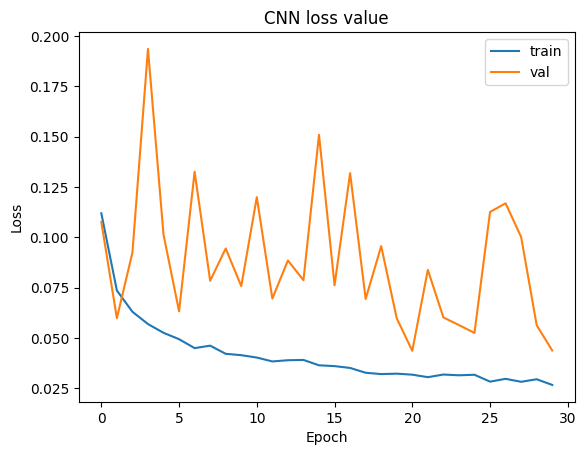

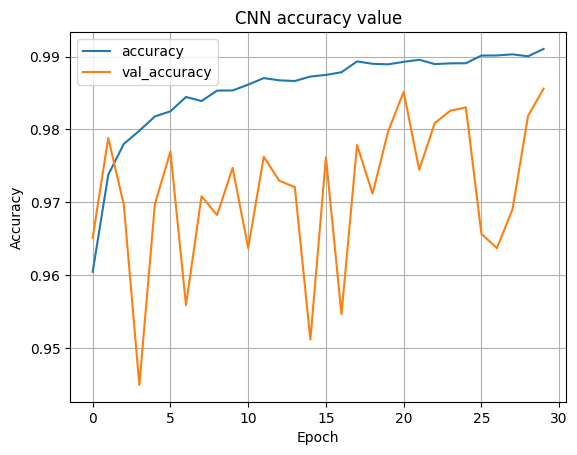

In [26]:
import matplotlib.pyplot as plt
# 绘制loss图
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("CNN loss value")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.grid(True)



# 绘制准确率
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("CNN accuracy value")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
test_loss, test_acc = model3.evaluate(test_generator)
print("Test accuracy:", test_acc)

704/704 [==============================] - 16s 22ms/step - loss: 1.1372 - accuracy: 0.6552
Test accuracy: 0.6552000045776367


704/704 [==============================] - 19s 24ms/step


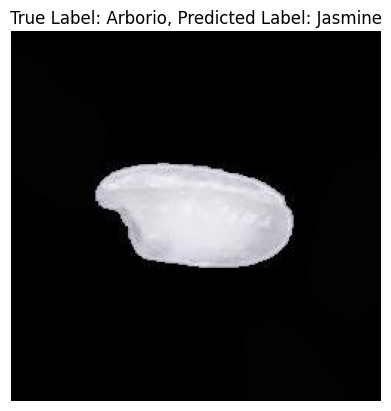

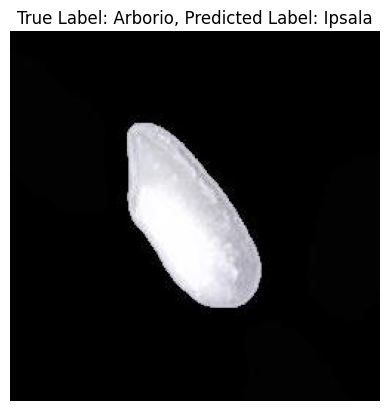

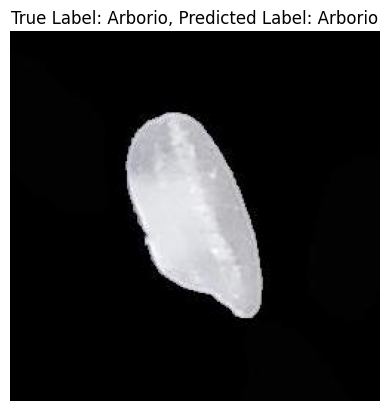

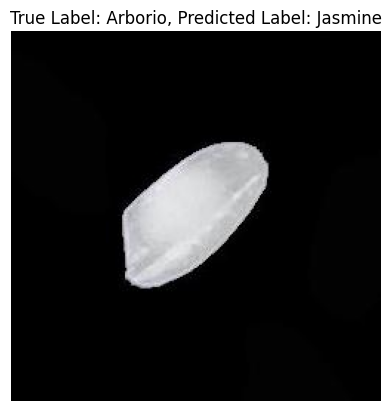

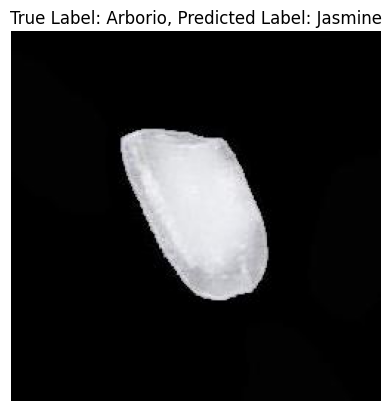

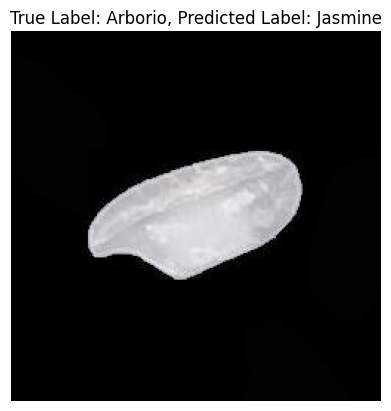

In [29]:
import numpy as np

predictions = model3.predict(test_generator)
from tensorflow.keras.preprocessing import image
# Retrieve the true class labels
true_labels = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Display the first few images with true and predicted labels
for i in range(6):  # Display the first 5 images (you can change this number)
    plt.figure()
    plt.imshow(image.load_img(os.path.join(test_dir, test_generator.filenames[i])))
    plt.title(f"True Label: {class_labels[true_labels[i]]}, Predicted Label: {class_labels[np.argmax(predictions[i])]}")
    plt.axis('off')
    plt.show()

704/704 [==============================] - 17s 24ms/step


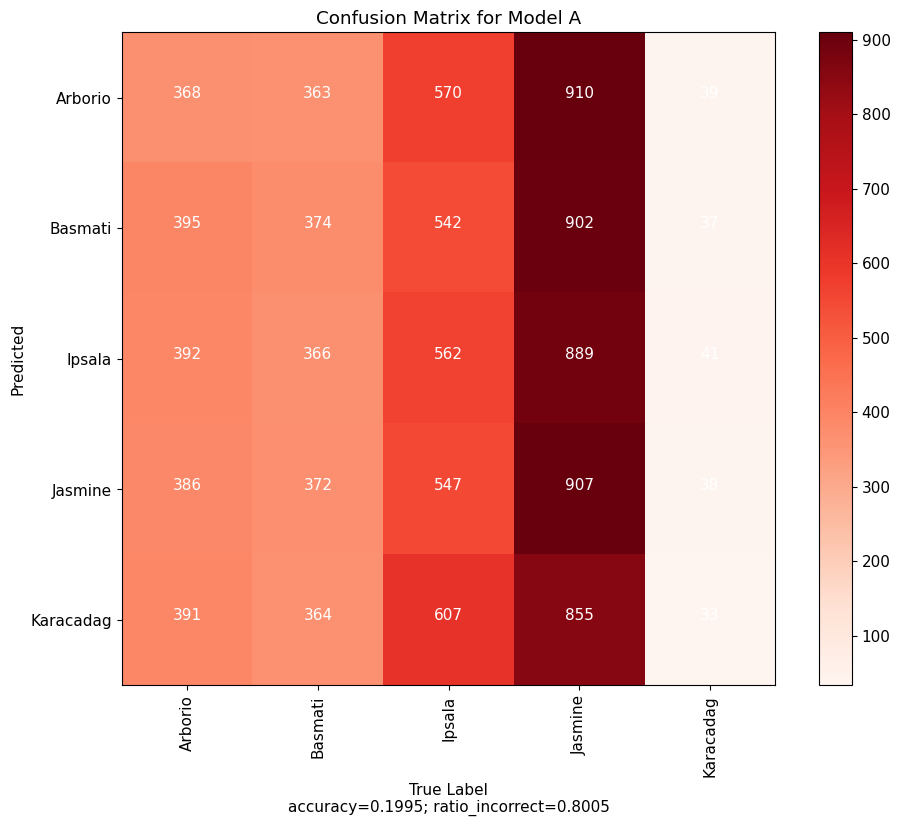

In [30]:
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(validation_generator, model3, test_generator, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions =  model3.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = validation_generator.classes
    
    plot_labels = np.array([i for i in validation_generator.class_indices.keys()])
    
    cm = confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm) / np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    # plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

# 使用方式：
plot_confusion_matrix(validation_generator,  model3, test_generator, 'Model A')

704/704 [==============================] - 16s 23ms/step


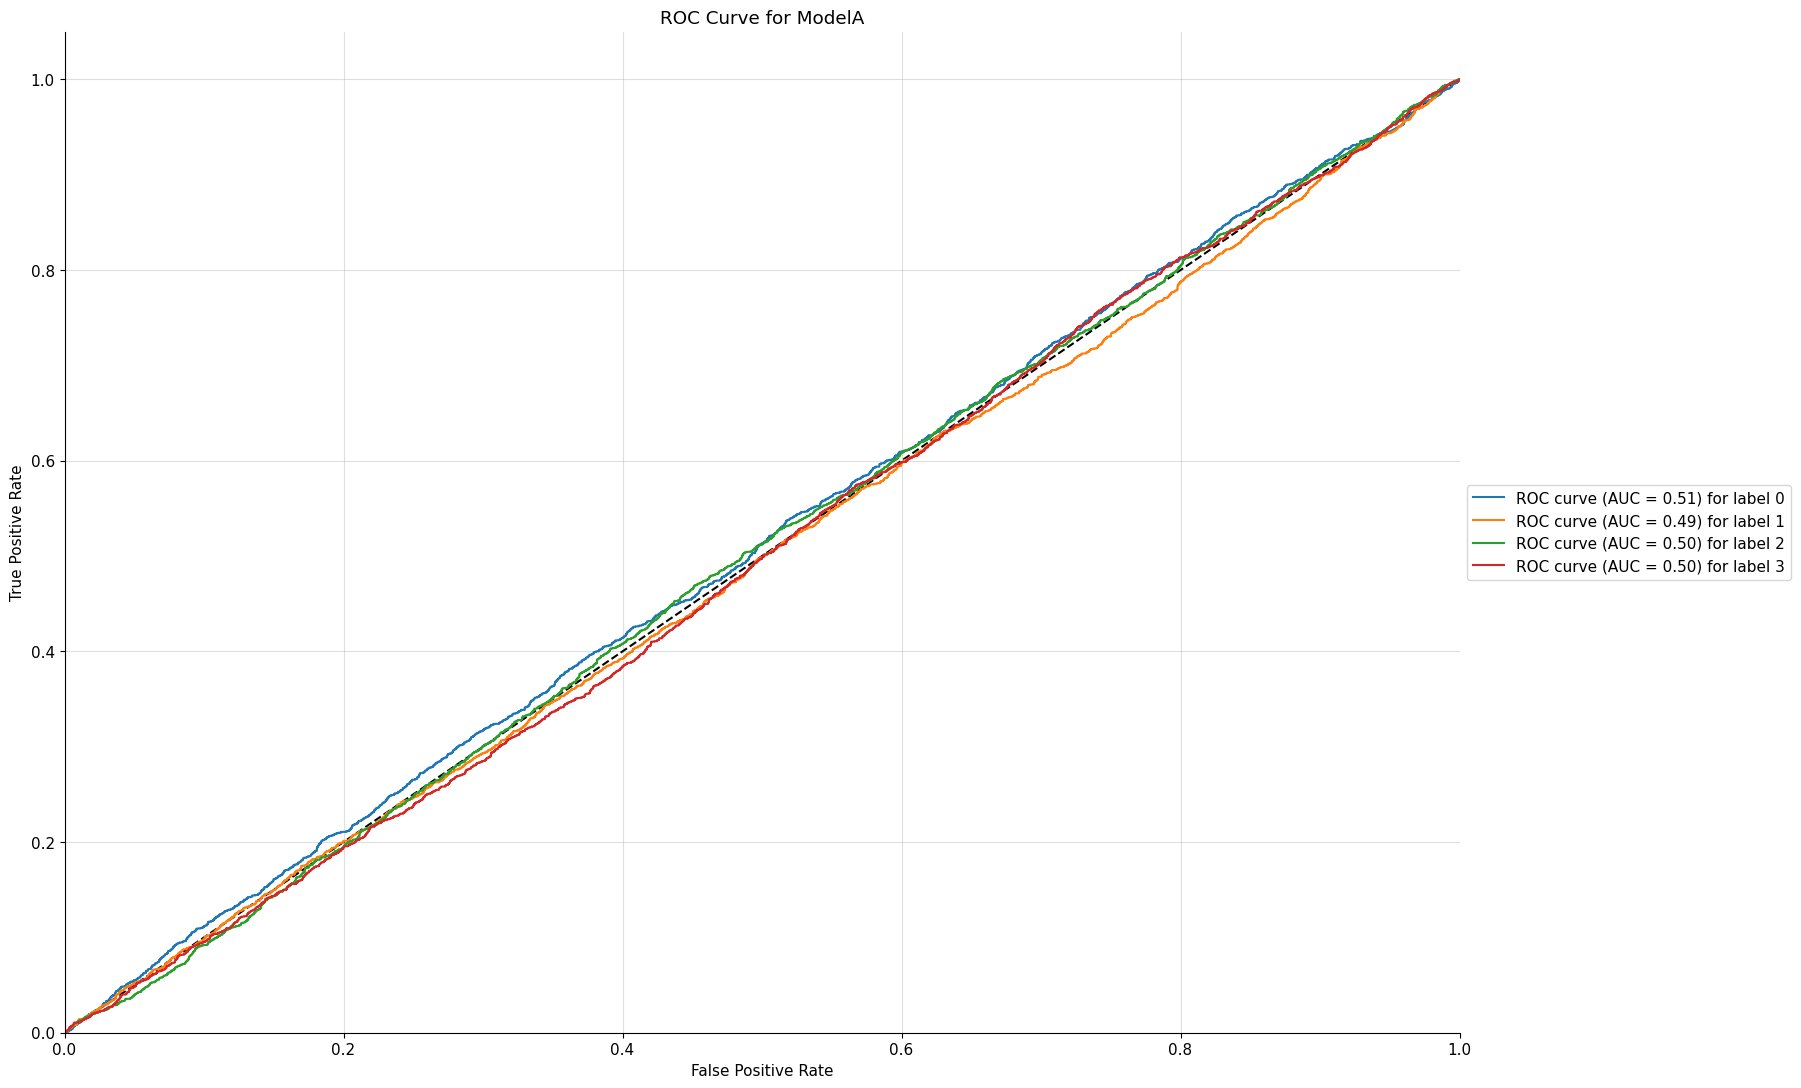

In [31]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_roc_curve(model3, test_generator, model_name):
    y_true = test_generator.classes
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')

    for i in range(4):
        ax.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f) for label %i' % (roc_auc[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_roc_curve(model3, test_generator, 'ModelA')

In [32]:
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

def class_report(validation_generator, model3, test_generator):
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    preds = np.argmax(predictions, axis=1)
    labels = validation_generator.classes
    names = np.array([i for i in validation_generator.class_indices.keys()])
    report_dict = classification_report(labels, preds, target_names=names, output_dict=True)
    df = pd.DataFrame.from_dict(report_dict).transpose()
    return df
class_report(validation_generator, model3, test_generator)

704/704 [==============================] - 16s 22ms/step


,precision,recall,f1-score,support
Arborio,0.188406,0.161778,0.174079,2250.000000
Basmati,0.199021,0.162667,0.179017,2250.000000
Ipsala,0.200141,0.251556,0.222922,2250.000000
Jasmine,0.189783,0.376444,0.252346,2250.000000
Karacadag,0.223404,0.018667,0.034454,2250.000000
accuracy,0.194222,0.194222,0.194222,0.194222
macro avg,0.200151,0.194222,0.172564,11250.000000
weighted avg,0.200151,0.194222,0.172564,11250.000000


In [34]:
from sklearn.metrics import confusion_matrix

def sensitivity_specificity(model3, test_generator):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)

    # 计算敏感性和特异性
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    return sensitivity, specificity

# 使用方式：
sensitivity, specificity = sensitivity_specificity(model3, test_generator)
print(f'Sensitivity: {sensitivity}, Specificity: {specificity}')

704/704 [==============================] - 19s 27ms/step
Sensitivity: 0.47688243064729197, Specificity: 0.5041666666666667


704/704 [==============================] - 16s 23ms/step


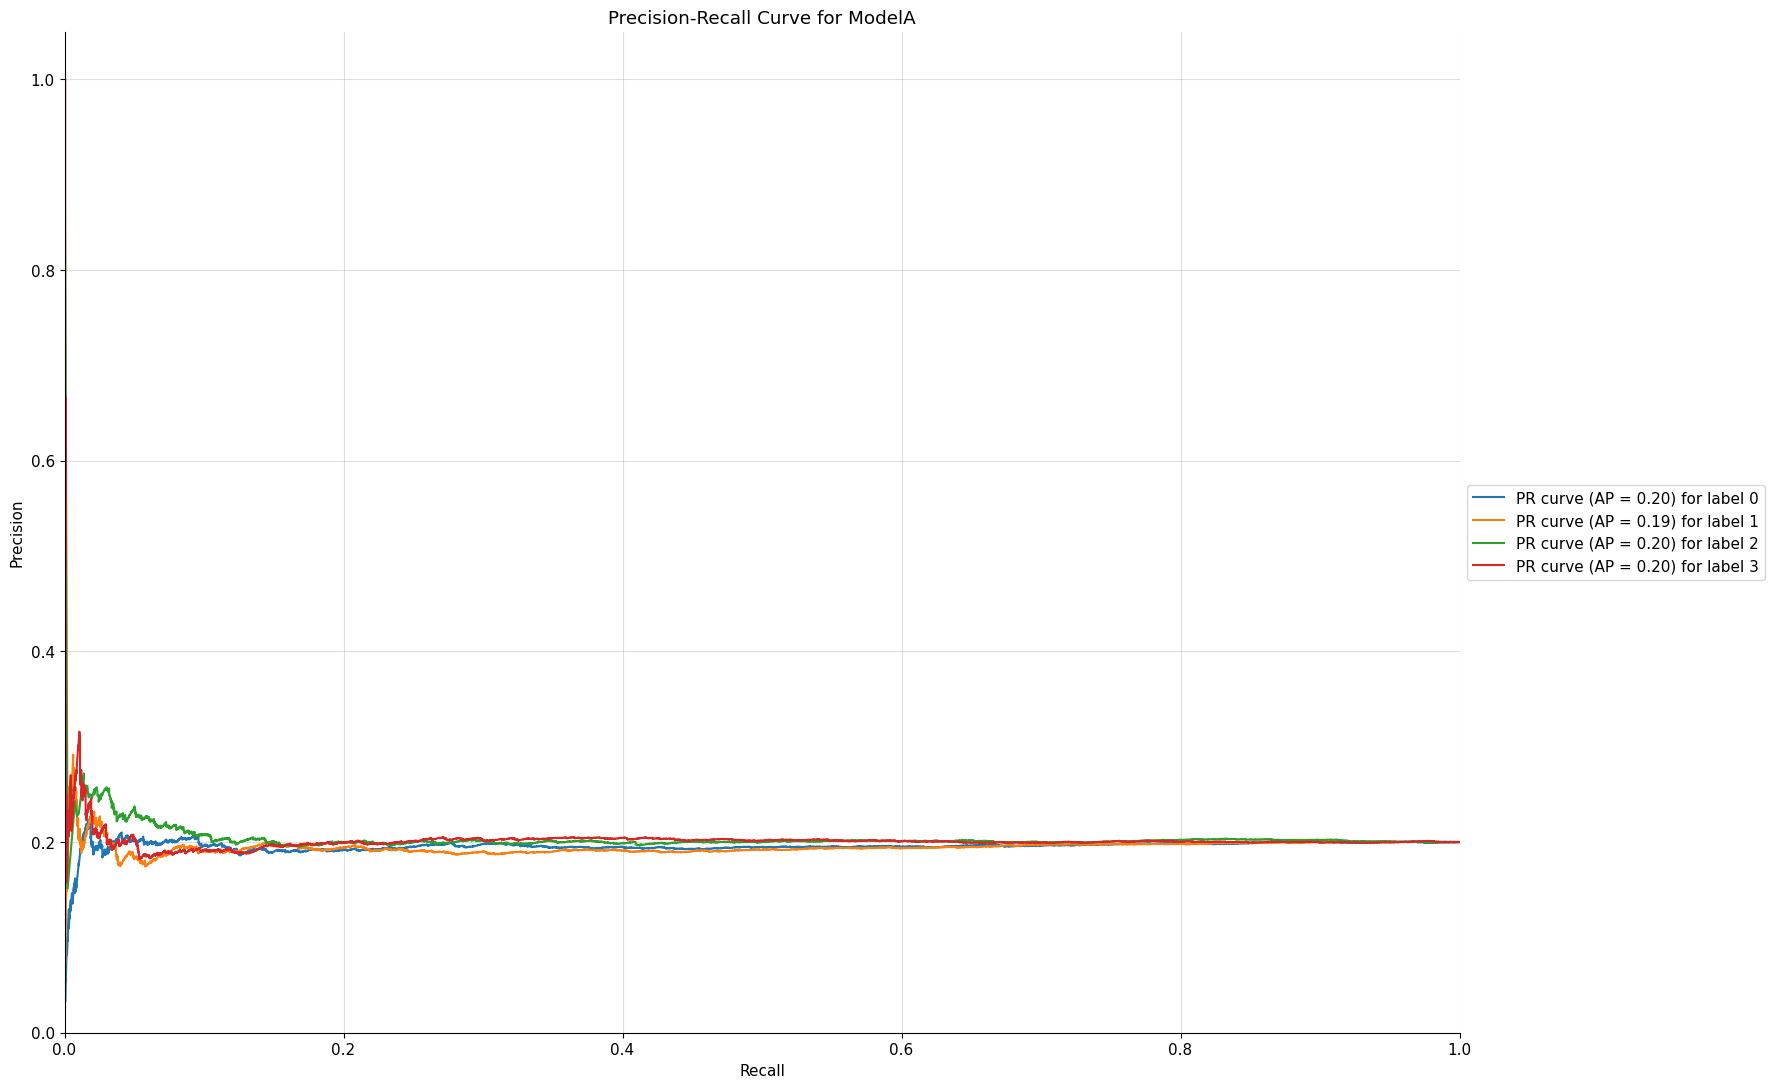

In [36]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def plot_precision_recall_curve(model3, test_generator, model_name):
    # 获取验证集上的真实标签
    y_true = test_generator.classes

    # 使用模型进行预测
    predictions = model3.predict(test_generator, steps=len(test_generator), verbose=1)

    # 初始化 Precision 和 Recall 字典
    precision = dict()
    recall = dict()
    average_precision = dict()

    # 计算每个类别的 Precision 和 Recall
    for i in range(4):
        precision[i], recall[i], _ = precision_recall_curve(y_true == i, predictions[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    # 绘制 Precision-Recall 曲线
    fig, ax = plt.subplots(figsize=(18, 13))
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'Precision-Recall Curve for {model_name}')

    for i in range(4):
        ax.plot(recall[i], precision[i], label='PR curve (AP = %0.2f) for label %i' % (average_precision[i], i))

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

# 使用方式：
plot_precision_recall_curve(model3, test_generator, 'ModelA')

In [ ]:
combined_model.save('rice_model.h1')